## Consumir dados API- Company Overview - www.alphavantage.co

### Capturar dados Básicos

In [34]:
!pip install python-dotenv
!pip install requests

In [35]:
from dotenv import load_dotenv
import os

load_dotenv()

# Acessando as variáveis:
api_key = os.getenv('API_KEY')
base_url = os.getenv('BASE_URL_OVERVIEW')

In [36]:
import requests
import json

# Função para obter o resumo de uma empresa
def get_company_overview(symbol):
    url = f'{base_url}&symbol={symbol}&apikey={api_key}'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if symbol in data['Symbol']:
            # Extract specific data points of interest
            company_name = data['Name']
            description = data['Description']
            sector = data['Sector']
            industry = data['Industry']
            market_cap = float(data['MarketCapitalization'])  # Assuming value is a string, convert to float if necessary
            # ... (extract other desired data points)

            # Print or return the extracted information
            print(f"Company Name: {company_name}")
            print(f"Description: {description}")
            print(f"Sector: {sector}")
            print(f"Industry: {industry}")
            print(f"Market Capitalization: {market_cap:,.2f}")  # Format market cap with commas and 2 decimal places
            # ... (print other extracted data points)

            return data  # Alternatively, return the entire overview dictionary
        else:
            print(f"Erro: 'Overview' não encontrado para {symbol}")
    else:
        print(f"Erro na requisição: {response.status_code}")
        return None
    
# Lista de símbolos das empresas
symbols = ['GOOGL', 'AAPL', 'NVDA']

# Loop para obter o resumo de cada empresa
for symbol in symbols:
    overview = get_company_overview(symbol)
    print(f"Resumo da {symbol}:")
    print(json.dumps(overview, indent=4))

Company Name: Alphabet Inc Class A
Description: Alphabet Inc. is an American multinational conglomerate headquartered in Mountain View, California. It was created through a restructuring of Google on October 2, 2015, and became the parent company of Google and several former Google subsidiaries. The two co-founders of Google remained as controlling shareholders, board members, and employees at Alphabet. Alphabet is the world's fourth-largest technology company by revenue and one of the world's most valuable companies.
Sector: TECHNOLOGY
Industry: SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC.
Market Capitalization: 2,061,374,587,000.00
Resumo da GOOGL:
{
    "Symbol": "GOOGL",
    "AssetType": "Common Stock",
    "Name": "Alphabet Inc Class A",
    "Description": "Alphabet Inc. is an American multinational conglomerate headquartered in Mountain View, California. It was created through a restructuring of Google on October 2, 2015, and became the parent company of Google and severa

## Analise Técnica

### Preparar dados histórico dos preços das ações

In [37]:
!pip install yfinance

In [38]:
import yfinance as yf
import pandas as pd

In [39]:
# Obtendo dados históricos da Apple
#for symbol in symbols:
def obter_preco_acoes(symbol, start, end):
    return yf.download(symbol, start, end) 


In [40]:
start = input('Data inicio:')
end = input('Data fin: ')

# Criar um DataFrame para armazenar os dados
data = pd.DataFrame()

In [41]:
for symbol in symbols:
    df = obter_preco_acoes(symbol, start, end)
    df['symbol'] = symbol
    data = pd.concat([data, df])


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Informações Básicas

In [42]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2023-01-03,89.589996,91.050003,88.519997,89.120003,89.017838,28131200,GOOGL
2023-01-04,90.349998,90.650002,87.269997,88.080002,87.979027,34854800,GOOGL
2023-01-05,87.470001,87.570000,85.900002,86.199997,86.101181,27194400,GOOGL
2023-01-06,86.790001,87.690002,84.860001,87.339996,87.239868,41381500,GOOGL
2023-01-09,88.360001,90.050003,87.860001,88.019997,87.919090,29003900,GOOGL


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1209 entries, 2023-01-03 to 2024-08-09
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1209 non-null   float64
 1   High       1209 non-null   float64
 2   Low        1209 non-null   float64
 3   Close      1209 non-null   float64
 4   Adj Close  1209 non-null   float64
 5   Volume     1209 non-null   int64  
 6   symbol     1209 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 75.6+ KB


In [44]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1.209000e+03
mean,123.844973,125.297887,122.553582,123.999414,123.677907,1.861187e+08
std,56.729223,57.121457,56.403997,56.760586,56.516753,2.192916e+08
min,14.474000,14.564000,14.034000,14.265000,14.256833,1.024210e+07
25%,85.077003,87.570000,83.417000,85.774002,85.766960,3.466240e+07
50%,133.119995,134.419998,131.360001,133.289993,132.517914,5.676710e+07
75%,173.289993,174.710007,171.889999,173.500000,172.775894,3.704530e+08
max,236.479996,237.229996,233.089996,234.820007,234.548523,1.543911e+09


### Candlestick

In [45]:
!pip install mplfinance
!pip install seaborn

In [46]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns

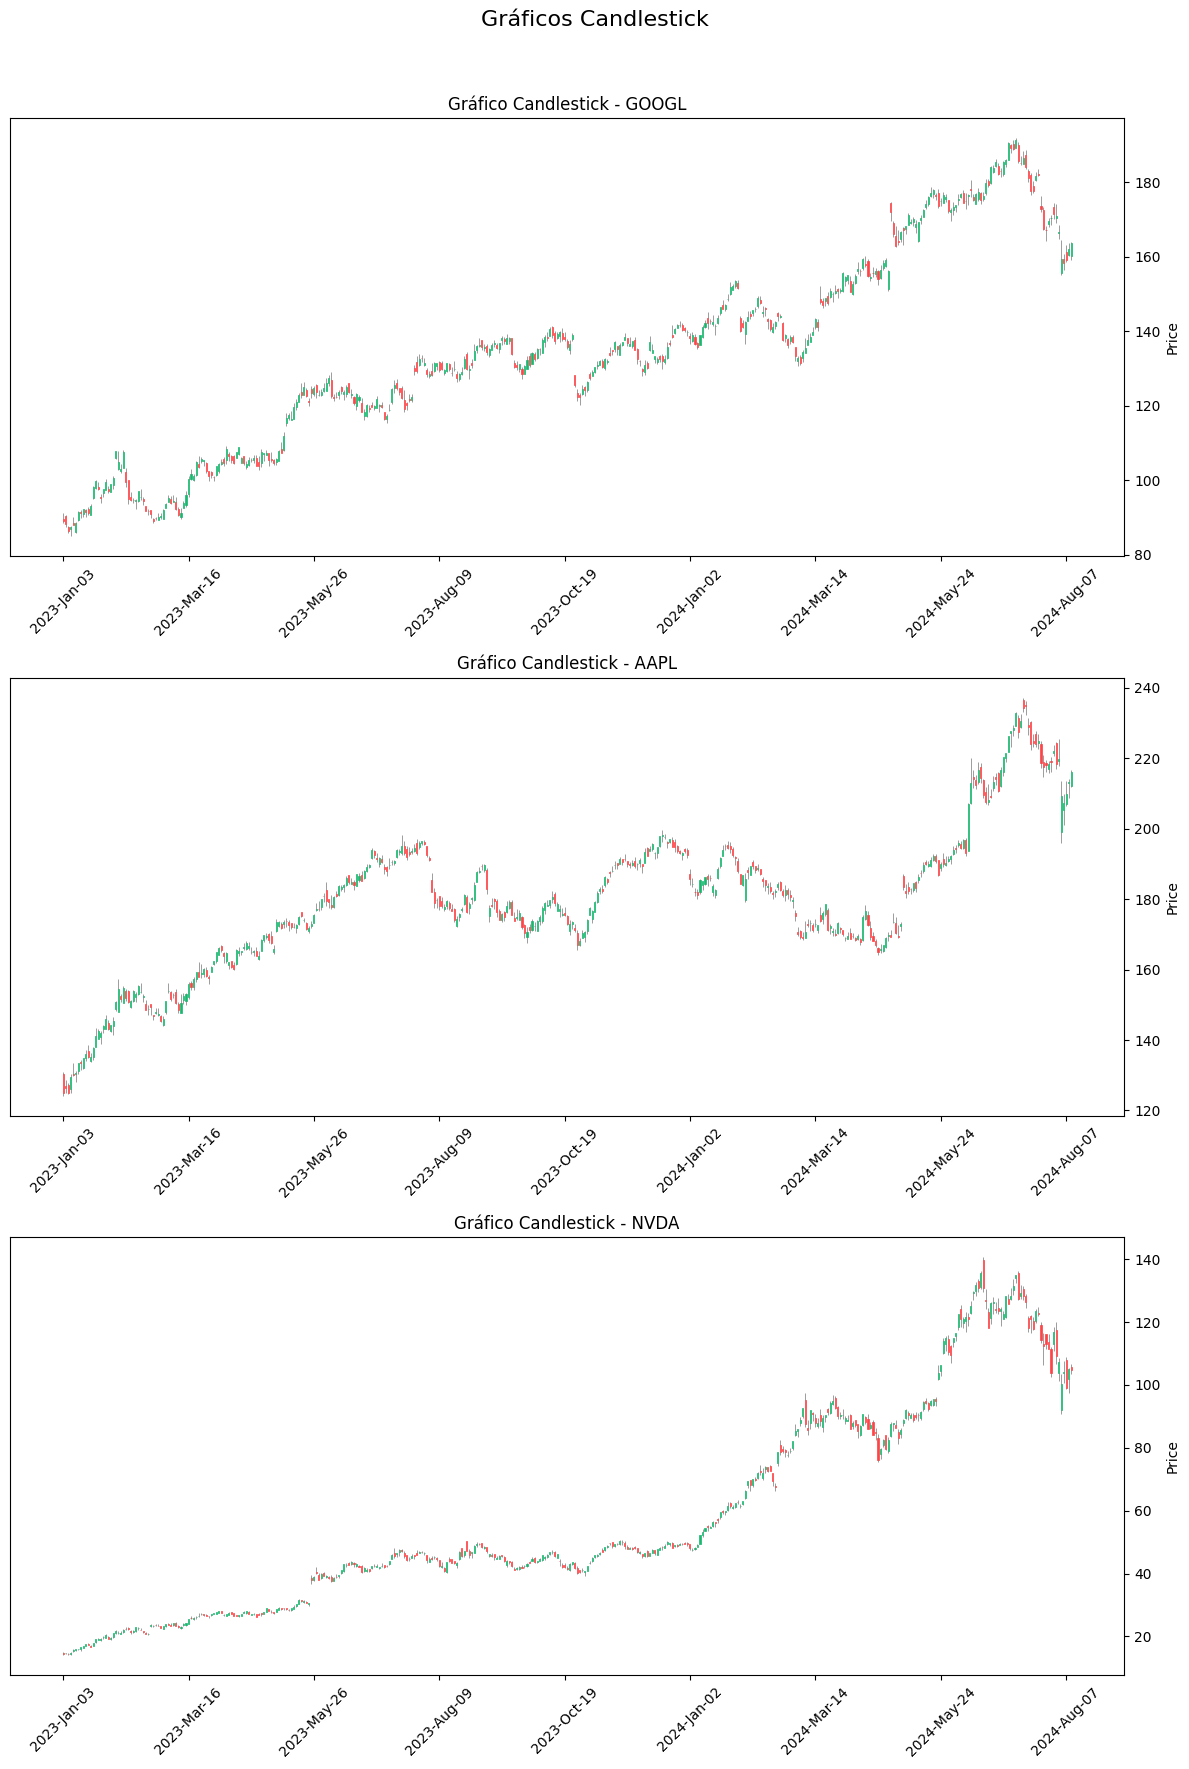

In [47]:

# Criar uma figura com múltiplos subplots
fig, axes = plt.subplots(nrows=len(symbols), ncols=1, figsize=(12, 6 * len(symbols)))

# Ajusta o layout para evitar sobreposição
fig.tight_layout(pad=4.0)

# Se houver apenas um gráfico, axes será um único eixo, então transforme em uma lista
if len(symbols) == 1:
    axes = [axes]

# Configura os gráficos de candlestick para cada símbolo
for i, symbol in enumerate(symbols):
    # Verificar se o símbolo existe no DataFrame
    if symbol in data['symbol'].values:
        group = data[data['symbol'] == symbol]
        ax = axes[i]

        # Plota o gráfico de candlestick
        mpf.plot(group[['Open', 'High', 'Low', 'Close']], type='candle', style='yahoo', ax=ax)

        # Define o título do gráfico
        ax.set_title(f'Gráfico Candlestick - {symbol}', fontsize=12)
    else:
        print(f"O símbolo '{symbol}' não foi encontrado no DataFrame.")

# Adiciona um título geral para a figura
fig.suptitle('Gráficos Candlestick', fontsize=16)

# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Exibir os gráficos
plt.show()

### Indicadores Técnicos

#### Calcular Médias Moveis Simples - MMS

In [48]:
def calculate_sma(data, column, window_size):
  """
  Calculates the Simple Moving Average (SMA) for a given column and window size.

  Args:
    data: Pandas DataFrame containing the data.
    column: The name of the column to calculate the SMA for.
    window_size: The number of periods for the SMA calculation.

  Returns:
    A Pandas Series containing the SMA values.
  """

  sma = data[column].rolling(window=window_size).mean()
  return sma

# Exemplo de uso:
data['MMS_15'] = calculate_sma(data, 'Close', 15)

#Preencher DataFrame com próximo valor válido
data['MMS_15'] = calculate_sma(data, 'Close', 15).bfill()

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1209 entries, 2023-01-03 to 2024-08-09
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1209 non-null   float64
 1   High       1209 non-null   float64
 2   Low        1209 non-null   float64
 3   Close      1209 non-null   float64
 4   Adj Close  1209 non-null   float64
 5   Volume     1209 non-null   int64  
 6   symbol     1209 non-null   object 
 7   MMS_15     1209 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 85.0+ KB


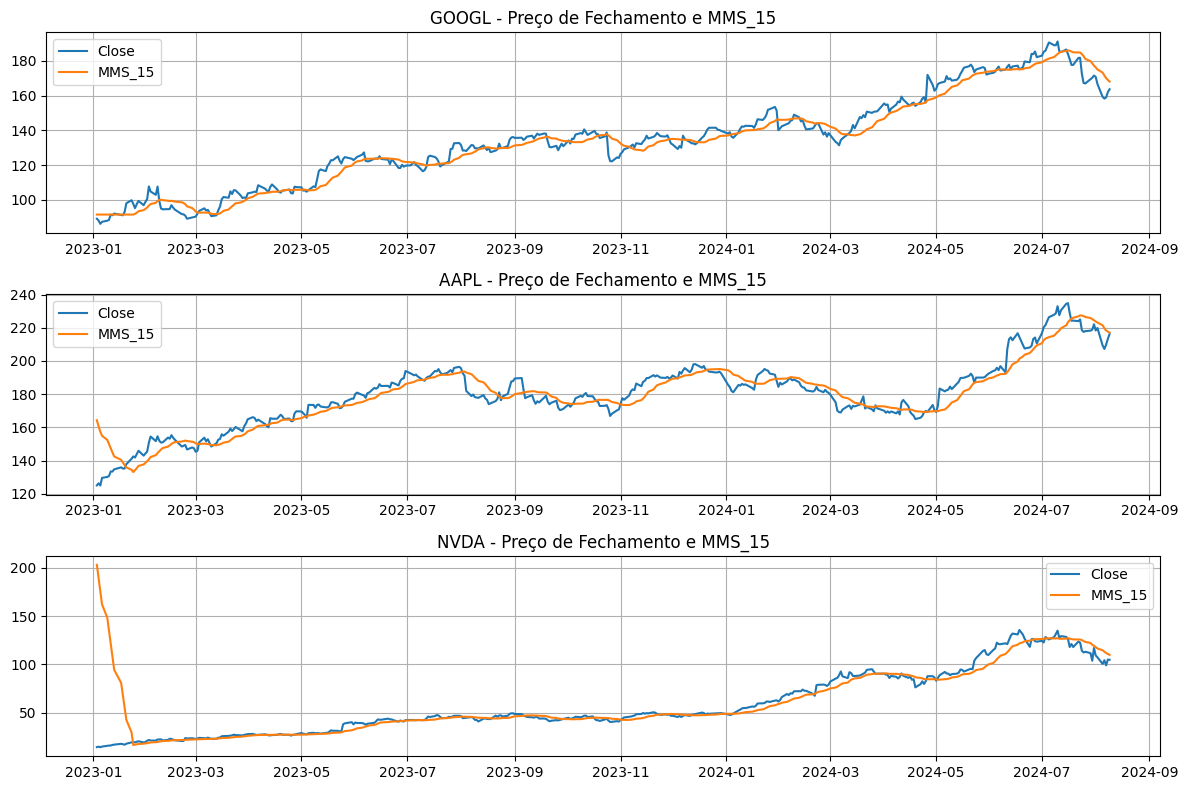

In [50]:
#import pandas as pd
#import matplotlib.pyplot as plt

# Filtrando o DataFrame para as ações desejadas
filtered_data = data[data['symbol'].isin(symbols)]

# Criando subplots para visualizar múltiplos gráficos em uma mesma figura
fig, axes = plt.subplots(nrows=len(symbols), figsize=(12, 8))

# Iterando sobre as ações e criando gráficos
for i, symbol in enumerate(symbols):
    symbol_data = filtered_data[filtered_data['symbol'] == symbol]
    axes[i].plot(symbol_data.index, symbol_data['Close'], label='Close')
    axes[i].plot(symbol_data.index, symbol_data['MMS_15'], label='MMS_15')
    axes[i].set_title(f"{symbol} - Preço de Fechamento e MMS_15")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

#### MACD para gerar sinais de compra e venda

In [51]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculando o MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    """
    Calcula o MACD, a linha de sinal e o histograma.

    Args:
        data: DataFrame com os dados.
        short_period: Período da média móvel curta (default: 12).
        long_period: Período da média móvel longa (default: 26).
        signal_period: Período da média móvel do sinal (default: 9).

    Returns:
        Um DataFrame com as colunas MACD, signal e hist.
    """

    short_ema = data['Close'].ewm(span=short_period, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    hist = macd - signal
    return pd.DataFrame({'macd': macd, 'signal': signal, 'hist': hist})

# Adicionando o MACD ao DataFrame
macd_data = calculate_macd(data)
data = pd.concat([data, macd_data], axis=1)

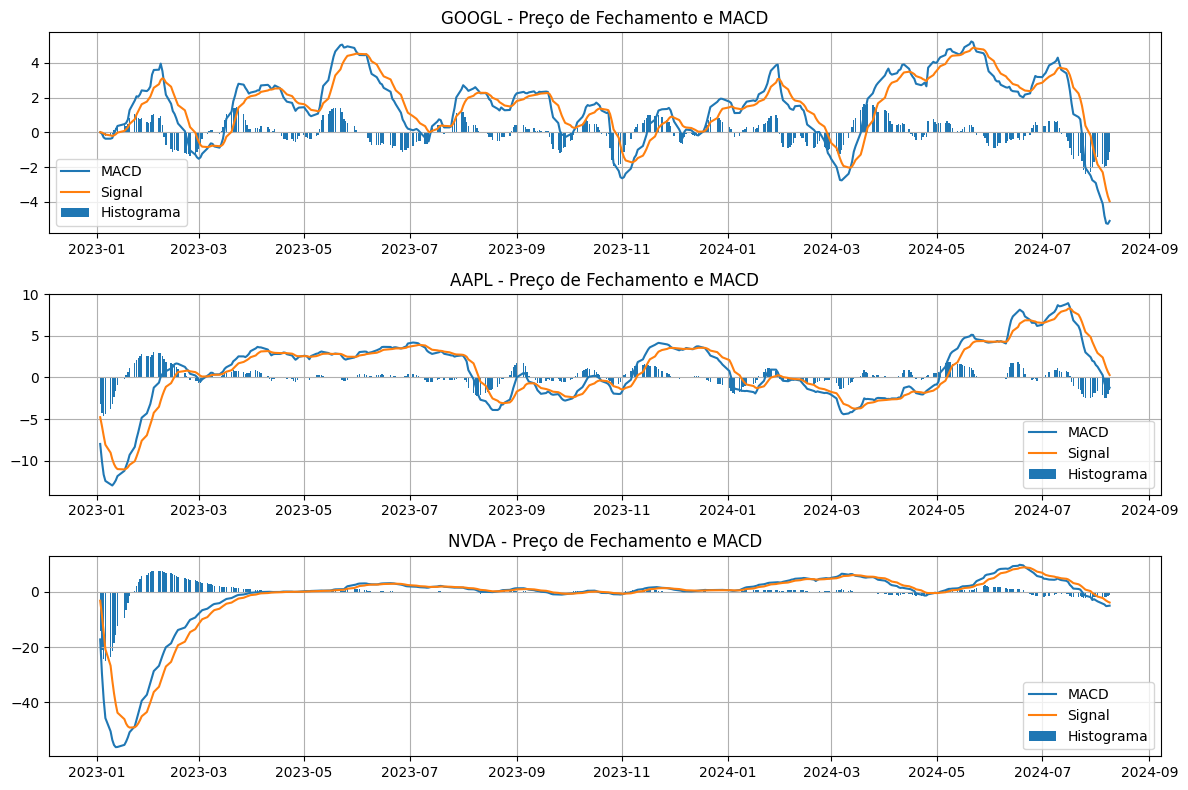

In [55]:
#import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

# Verificando e preenchendo valores NaN (se necessário)
data = data.ffill()  # Preenche com o valor anterior

# Criando subplots
fig, axes = plt.subplots(nrows=len(symbols), figsize=(12, 8))

for i, symbol in enumerate(symbols):
    symbol_data = data[data['symbol'] == symbol]

    # Plotando o preço de fechamento, MMS_15 e MACD
    #axes[i].plot(symbol_data.index, symbol_data['Close'], label='Close')
    #axes[i].plot(symbol_data.index, symbol_data['MMS_15'], label='MMS_15')
    axes[i].plot(symbol_data.index, symbol_data['macd'], label='MACD')
    axes[i].plot(symbol_data.index, symbol_data['signal'], label='Signal')
    axes[i].bar(symbol_data.index, symbol_data['hist'], label='Histograma')

    # Adicionando título, legenda e grid
    axes[i].set_title(f"{symbol} - MACD x Signal / Histograma")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()